# **Building Tensorflow Input Pipelines using tf.data with Keras**

# **1] Objective**

The objective here is to demonstrates how to plug **TensorFlow Datasets(TFDS) or any datasets using TensorFlow Input Pipelines into a Keras model.**

# **2] Data Description**

In this exercise, we'll using the same handwritten digits **MNIST** dataset which we have used for building the Multiclass Classification Neural Network.

MNIST(Modified national Institute of standards and Technology database) is a large dataset of 70,000 handwritten digits. It has a training set of 60,000 examples and a test set of 10,000 examples.

There are 10 classes:
    
  * Digits from 0 to 9
   

# **3] Importing the libraries**

In [25]:
# Import the libraries
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

In [12]:
# check the Tensroflow and keras versions
print("Tensorflow version ::",tf.__version__)
print("Keras Version ::",tf.keras.__version__)

Tensorflow version :: 2.18.0
Keras Version :: 3.8.0


# **4] Steps to build tensorflow input pipelines using tf.data with Keras:**

Step 1: Create your input pipeline using **tf.data**

  1.1] Load a dataset

  1.2] Build a Training Pipeline

  1.3] Build an Evaluation Pipeline

Step 2: Create and train the model using **Keras**

  2.1] Create the model

  2.2] Train the model
  

# **4.1] Create your input pipeline using tf.data**

# **4.1.1] Load a dataset from Tensorflow Datasets(TFDS)**

In [13]:
# Import the tensorflow datasets library to load the dataset
import tensorflow_datasets as tfds

Load the MNIST dataset with the following arguments:

  * **shuffle_files=True:** The MNIST data is only stored in a single file, but for larger datasets with multiple files on disk, it's good practice to shuffle them when training.

  * **as_supervised=True:** Return a tuple(img,label) instead of a dictionary {'image':img,'label':label}.

In [14]:
# Load the MNIST dataset

(ds_train,ds_test),ds_info=tfds.load(
    'mnist',
    split=['train','test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True
)

 # If we want the validation set also, then we can use below code as:
 # 1. (ds_train,ds_val,ds_test)
 # 2. split=["train[:80%]","train[80%:100%]","test"],

In [15]:
# Check the number of examples in train and test split
ds_train.cardinality().numpy(), ds_test.cardinality().numpy()

(60000, 10000)

In [16]:
ds_info

tfds.core.DatasetInfo(
    name='mnist',
    full_name='mnist/3.0.1',
    description="""
    The MNIST database of handwritten digits.
    """,
    homepage='http://yann.lecun.com/exdb/mnist/',
    data_dir='/root/tensorflow_datasets/mnist/3.0.1',
    file_format=tfrecord,
    download_size=11.06 MiB,
    dataset_size=21.00 MiB,
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=10000, num_shards=1>,
        'train': <SplitInfo num_examples=60000, num_shards=1>,
    },
    citation="""@article{lecun2010mnist,
      title={MNIST handwritten digit database},
      author={LeCun, Yann and Cortes, Corinna and Burges, CJ},
      journal={ATT Labs [Online]. Available: http://yann.lecun.com/exdb/mnist},
      volume={2},
      year={2010}
    }""",
)

In [17]:
ds_info.features['label'].names

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

In [18]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(28, 28, 1), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
})

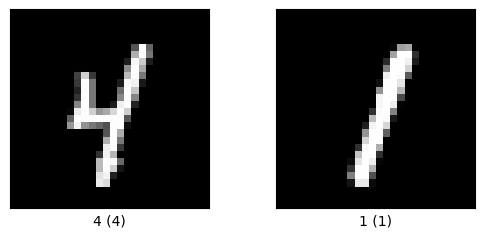

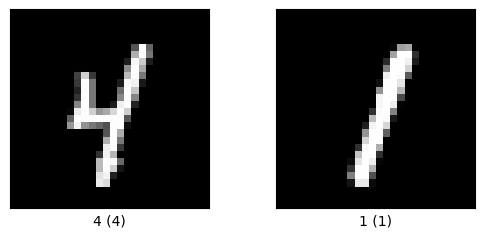

In [19]:
tfds.show_examples(ds_train,ds_info,rows=1,cols=2)

# **4.1.2] Building a Training Pipeline**

Apply the following transformations:

  * **tf.data.Dataset.map:** TFDS provide images of type tf.uint8, while the model expects tf.float32. Therefore, you need to normalize the images.

  * **tf.data.Dataset.cache:** As you fit the dataset in memory, cache it before shuffling for a better performance.

   **Note:** Random transformation should be applied after caching.

  * **tf.data.Dataset.batch:** Batch elements of the dataset after suffling to get unique batches at each epoch.

  * **tf.data.Dataset.prefetch:** It is good practice to end the pipeline by prefetching for performance.
  


**Normalizing the data**
The pixels values ranges from 0-255 represents the RGB(red,Green and Blue) color values.

Normalize the values using **Min-Max Scaler.**

Formula is: **X = (X-X_min)/(X_max-X_min)=X/255**

In [20]:
# Normalizing the datapoints within the scale of 0-1 using Min-Max Scaler.
def normalize_img(image,label):
  """Normalizes images: `uint8` -> `float32` . """
  return tf.cast(image,tf.float32)/255., label

In [26]:
# Create a training input pipeline
# Normalize each image within the sclae of 0-1 using .map()

ds_train=ds_train.map(normalize_img,num_parallel_calls=tf.data.AUTOTUNE)

# Cache the dataset for better performance using .cache()
ds_train=ds_train.cache()

# Shuffle the dataset for better performance using .shuffle()
ds_train=ds_train.shuffle(ds_info.splits['train'].num_examples)

# Dividing the dataset into batches using .batch()
ds_train = ds_train.batch(28)

# Prefetch the elements from the dataset using .prefetch()
ds_train = ds_train.prefetch(tf.data.AUTOTUNE)

# **4.1.3] Build an Evaluation Pipeline**

Your testing pipeline is similar to the training pipeline with small differences:

  * You don't need to call tf.data.Dataset.shuffle.

In [28]:
# Create an evaluation input pipeline
# Normalize each image within the scale of 0-1 using .map()

ds_test = ds_test.map(normalize_img,num_parallel_calls=tf.data.AUTOTUNE)

# dividing the dataset into batches using .batch()

ds_test = ds_test.batch(28)

# cache the dataset for better performance using .cahce()
ds_test = ds_test.cache()

# Prefectch the elements from the dataset using .prefetch()
ds_test = ds_test.prefetch(tf.data.AUTOTUNE)

# **4.2] Create and train the neural using Keras**

Plug the TFDS input pipeline into a simple Keras model, compile the model, and train it.

In [29]:
# Import Libraries for Building sequential models with dense layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten,Dense,Activation

In [30]:
# Create the Sequential model.

model = Sequential(
    [
        Flatten(input_shape=(28,28)),
        Dense(512, activation='sigmoid',name='Hidden_Layer1'),
        Dense(128,activation='sigmoid',name='Hiddne_Layer2'),
        Dense(10,activation='softmax',name='Ouput_Layer')

    ]
)

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten (Flatten)                    │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Hidden_Layer1 (Dense)                │ (None, 512)                 │         401,920 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Hiddne_Layer2 (Dense)                │ (None, 128)                 │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Ouput_Layer (Dense)                  │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 468,874 (1.79 MB)

 Trainable params: 468,874 (1.79 MB)

 Non-trainable params: 0 (0.00 B)

In [37]:
# Compile the Model
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]

)

# Train the model
multiclass_classifier = model.fit(
    ds_train,
    epochs=20,
    validation_data=ds_test
)

Epoch 1/20
2143/2143 ━━━━━━━━━━━━━━━━━━━━ 20s 6ms/step - loss: 0.5903 - sparse_categorical_accuracy: 0.8380 - val_loss: 0.1915 - val_sparse_categorical_accuracy: 0.9433
Epoch 2/20
2143/2143 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - loss: 0.1594 - sparse_categorical_accuracy: 0.9516 - val_loss: 0.1214 - val_sparse_categorical_accuracy: 0.9634
Epoch 3/20
2143/2143 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - loss: 0.0947 - sparse_categorical_accuracy: 0.9718 - val_loss: 0.0878 - val_sparse_categorical_accuracy: 0.9722
Epoch 4/20
2143/2143 ━━━━━━━━━━━━━━━━━━━━ 21s 6ms/step - loss: 0.0618 - sparse_categorical_accuracy: 0.9812 - val_loss: 0.0767 - val_sparse_categorical_accuracy: 0.9756
Epoch 5/20
2143/2143 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - loss: 0.0443 - sparse_categorical_accuracy: 0.9860 - val_loss: 0.0682 - val_sparse_categorical_accuracy: 0.9781
Epoch 6/20
2143/2143 ━━━━━━━━━━━━━━━━━━━━ 22s 7ms/step - loss: 0.0312 - sparse_categorical_accuracy: 0.9901 - val_loss: 0.0768 - val_sparse_categorical_acc

# **5]. Evaluate a trained network.**

In [38]:
# Evaluate our neural network using test dataset
score =  model.evaluate(ds_test,verbose=0)
print('Test loss:',score[0])
print('Test accuracy:',score[1])

Test loss: 0.0786326676607132
Test accuracy: 0.9818999767303467


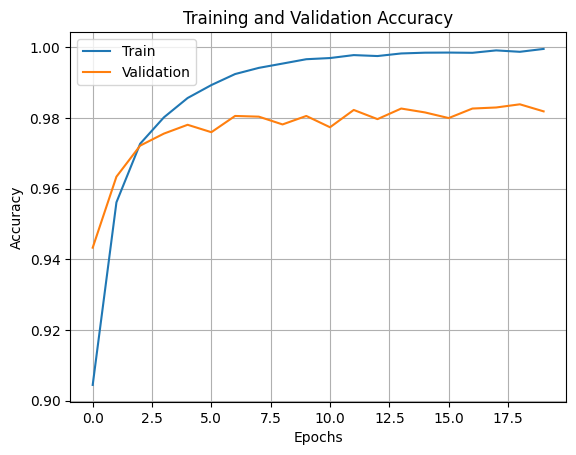

In [39]:
# Plot training accuracy and validation accuracy
plt.plot(multiclass_classifier.history['sparse_categorical_accuracy'])
plt.plot(multiclass_classifier.history['val_sparse_categorical_accuracy'])
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Train','Validation'])
plt.grid()
plt.show()

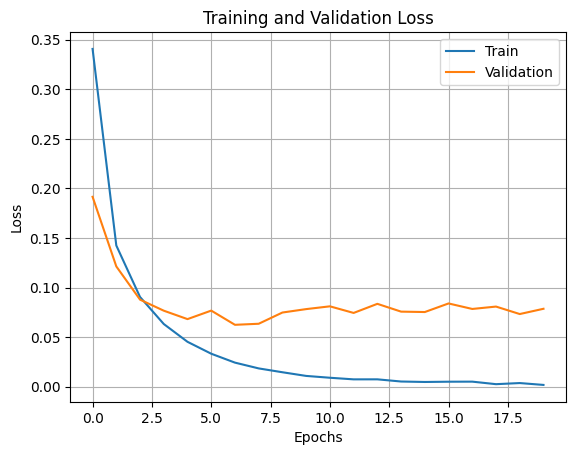

In [40]:
# Plot training loss and validation loss
plt.plot(multiclass_classifier.history['loss'])
plt.plot(multiclass_classifier.history['val_loss'])
plt.title('Training and Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Train','Validation'])
plt.grid()
plt.show()

# **6]. Inference or Prediction using a trained neural network.**


In [41]:
# take the batch of 128 data points from ds_test for predictions
image_batch, label_batch = next(iter(ds_test))

In [42]:
label_batch[:10]

<tf.Tensor: shape=(10,), dtype=int64, numpy=array([2, 0, 4, 8, 7, 6, 0, 6, 3, 1])>

In [43]:
# Predictions on test dataset using predict() function
y_pred = model.predict(image_batch)
y_pred[:10]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


array([[9.37452156e-14, 1.64689151e-08, 9.99999940e-01, 1.80662620e-11,
        2.37249734e-11, 2.99533415e-14, 9.18154008e-12, 6.03952912e-12,
        2.31962591e-11, 1.17129112e-13],
       [9.99996006e-01, 4.69873203e-11, 6.68910927e-10, 4.63823337e-12,
        1.96870732e-12, 4.27626823e-08, 3.91869071e-06, 1.94146171e-10,
        7.28276328e-10, 3.47390484e-11],
       [4.63896120e-13, 1.17136550e-10, 4.78314567e-12, 2.20556928e-12,
        9.99998987e-01, 3.74052975e-13, 3.56874144e-13, 4.02781467e-07,
        8.25023209e-12, 6.33014906e-07],
       [5.16375796e-11, 1.57121552e-10, 3.27097073e-12, 5.74937264e-10,
        1.08374267e-13, 2.15103657e-10, 4.28180373e-11, 2.25604854e-13,
        9.99999940e-01, 1.49756174e-09],
       [2.26016827e-11, 3.46642770e-10, 5.74589473e-11, 7.19739546e-10,
        9.41277126e-11, 4.13001881e-14, 6.55675499e-17, 9.99999940e-01,
        3.17108340e-12, 8.89246810e-09],
       [6.04787198e-09, 1.43189363e-10, 2.99255043e-12, 6.03656556e-13,
   

In [44]:
y_pred=np.array([np.argmax(pred) for pred in y_pred])

In [45]:
y_pred[:10],label_batch[0:10]

(array([2, 0, 4, 8, 7, 6, 0, 6, 3, 1]),
 <tf.Tensor: shape=(10,), dtype=int64, numpy=array([2, 0, 4, 8, 7, 6, 0, 6, 3, 1])>)

In [46]:
# Everything is same as compared to previous exercises which we did, only difference here is that we have passed the data to keras
# model by creating the input pipilines which are more optimized and efficient.

# Function to create an input pipeline

def create_pipeline(ds,batch_size=32,buffer_size=1000,shuffle=True):
  # Normalize each image within the scale of 0-1 using .map()
  ds = ds_train.map(normalize_img,num_parallel_calls=tf.data.AUTOTUNE)

  # Cache the dataset fir better performance using .cache()
  ds = ds_train.cache()

  # Shuffle the elements of the dataset using .shuffle()
  if shuffle:
    ds = ds.shuffle(buffer_size)

  # Dividing the dataset into batches using .batch()
  ds = ds_train.batch(batch_size)

  # Prefetch the elements from the dataset using .prefetch()
  ds  = ds_train.prefetch(tf.data.AUTOTUNE)

  return ds


ds_train = create_pipeline(ds_train,shuffle=True)
ds_val = create_pipeline(ds_val,shuffle=False)
ds_test = create_pipeline(ds_test)


NameError: name 'ds_val' is not defined